In [1]:
%load_ext autoreload

In [2]:
import os
import csv
import cv2
from localizer import *
from models import *
from keras.models import *
from keras.layers import *
from keras import callbacks
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import h5py
%autoreload

Using TensorFlow backend.


Load Data

In [3]:
def split_dataset(X, ratio=0.8):
    cutoff = int(ratio * len(X))
    return X[:cutoff], X[cutoff:]
def preprocess_image(image):
    # resize 244 x 244 x 3
    image = cv2.resize(image, (244, 244))
    return np.uint32(image)

def scale_rssi(rssi):
    return (rssi + 100) * (1./70.)
def scale_xy():
    pass

In [4]:
lab_localizer = localizer()
lab_localizer.make_profile('test_prof', length=12)
print(lab_localizer)

Creating new profile: test_prof
----------------------------------------
Localizer
Wifi Device: wlan0
Profile: test_prof Length: 12
Routers:
    260453955621904
    260453955621906
    260453955621905
    260453955621907
    36168625175133
    48751578567808
    13640875216817
    13640875216818
    13640875216819
    13640875216831
    13640875216829
    13640875216830
----------------------------------------


In [5]:

def load_data(path, profile=None):
    wifi = []   # (len, num_cells_in_profile)
    mag = []    # (len, 2)
    img = []    # (len, 2, imgx, imgy, imgd)
    xy = []     # (len, 2)
    file_count = 0
    if profile is not None:
        for file_name in os.listdir(path):
            if os.path.isfile(path + file_name):
                print('-- loading from {}'.format(file_name))
                with open(path + file_name, 'r') as f:
                    reader = csv.reader(f)
                    for row in reader:
                        xy.append([float(row[0]), float(row[1])])
                        xy.append([float(row[0]), float(row[1])])
                        mag.append([float(row[2]), float(row[3])])
                        mag.append([float(row[2]), float(row[3])])
                        img1 = cv2.imread(row[5])
                        img1 = preprocess_image(img1)
                        img2 = cv2.imread(row[6])
                        img2 = preprocess_image(img2)
                        img.append(img1)
                        img.append(img2)
                        count = 0
                        wifi_row = []
                        for addr in profile:
                            for cell in row[7:]:
                                mac, rssi = cell.split(' ')
                                if addr == mac:
                                    wifi_row.append(scale_rssi(float(rssi)))
                                    break
                            else:
                                wifi_row.append(scale_rssi(-100.0))
                        wifi.append(wifi_row)
                        wifi.append(wifi_row)
            file_count += 1
        print('Loaded {} files from {}'.format(file_count, path))
        return np.array(wifi), np.array(mag), np.array(img), np.array(xy)
        
wifi, mag, images, y = load_data('../datasets/', lab_localizer.profile)
p = np.random.permutation(len(y))
wifi, mag, images, y = wifi[p], mag[p], images[p], y[p]

wifi_train, wifi_test = split_dataset(wifi)
mag_train, mag_test = split_dataset(mag)
images_train, images_test = split_dataset(images)
y_train, y_test = split_dataset(y)
print(wifi_train.shape)
print(mag_test.shape)
print(images.shape)

-- loading from 2017-07-13_15:14
-- loading from 2017-07-13_11:06
-- loading from 2017-07-13_15:15
-- loading from 2017-07-14_10:08
Loaded 6 files from ../datasets/
(256, 12)
(64, 2)
(320, 244, 244, 3)


Train

In [6]:

# define model inputs
wifi_input = Input(shape=(12,), dtype='float32')
mag_input = Input(shape=(2,), dtype='float32')
img_input = Input(shape=(244, 244, 3), dtype='float32')

wifi_branch = Dense(64, activation='relu')(wifi_input)
wifi_branch = Dense(64, activation='relu')(wifi_branch)
wifi_branch = Dense(64, activation='relu')(wifi_branch)

mag_branch = Dense(16, activation='relu')(mag_input)
mag_branch = Dense(16, activation='relu')(mag_branch)
mag_branch = Dense(16, activation='relu')(mag_branch)

img_branch = Conv2D(16, (2, 2))(img_input)
img_branch = Conv2D(24, (2, 2))(img_branch)
img_branch = Conv2D(24, (2, 2))(img_branch)
img_branch = Flatten()(img_branch)

merged = concatenate([wifi_branch, mag_branch, img_branch], axis=-1)
out = Dense(2, activation='linear')(merged)

model = Model([wifi_input, mag_input, img_input], out)
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 244, 244, 3)   0                                            
____________________________________________________________________________________________________
input_1 (InputLayer)             (None, 12)            0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 243, 243, 16)  208         input_3[0][0]                    
___________________________________________________________________________________________

In [7]:
epochs=10
batch_size=10

model_name = 'test_model'
if not os.path.exists('../models/' + model_name):
    os.makedirs('../models/' + model_name)

#Save the model after each epoch if the validation loss improved.
save_best = callbacks.ModelCheckpoint('../models/' + model_name + '/' + model_name + '.hdf5', monitor='val_loss', verbose=1, 
                                     save_best_only=True, mode='min')

#stop training if the validation loss doesn't improve for 5 consecutive epochs.
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                                     verbose=0, mode='auto')

callbacks_list = [save_best, early_stop]
model.fit([wifi_train, mag_train, images_train], y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=callbacks_list)
print(model.evaluate([wifi_test, mag_test, images_test], y_test, batch_size=batch_size))

Train on 230 samples, validate on 26 samples
Epoch 1/10
230/230 [==============================] - 29s - loss: 7279787.3058 - acc: 0.1522 - val_loss: 2655.3575 - val_acc: 0.0769
Epoch 2/10
230/230 [==============================] - 20s - loss: 2290.9717 - acc: 0.2304 - val_loss: 17328.6149 - val_acc: 0.5000
Epoch 3/10
230/230 [==============================] - 20s - loss: 1409547.4590 - acc: 0.4870 - val_loss: 499876.4141 - val_acc: 0.2692
Epoch 4/10
230/230 [==============================] - 20s - loss: 78582.9135 - acc: 0.2130 - val_loss: 89611.3233 - val_acc: 0.2692
Epoch 5/10
230/230 [==============================] - 20s - loss: 182527.9415 - acc: 0.2957 - val_loss: 313511.1947 - val_acc: 1.0000
Epoch 6/10
230/230 [==============================] - 20s - loss: 1868140.6071 - acc: 0.6000 - val_loss: 1231.0739 - val_acc: 0.6538
Epoch 7/10
230/230 [==============================] - 20s - loss: 5890.7779 - acc: 0.5739 - val_loss: 658167.1466 - val_acc: 0.0769
Epoch 8/10
230/230 [=====

Visualize

In [30]:
def plot_predictions(model, figure_name, x_vals, y_vals, eval_range=1.0):
    # generate color dictionary
    unique_collection_points = []
    for loc in y_vals:
        point = tuple(loc)
        if point not in unique_collection_points:
            unique_collection_points.append(point)
    for loc in y_vals:
        point = tuple(loc)
        if point not in unique_collection_points:
            unique_collection_points.append(point)
    num_points = len(unique_collection_points)

    color_map_iter = iter(cm.rainbow(np.linspace(0, 1, num_points)))
    colors = {}
    for loc in y_vals:
        try:
            colors[tuple(loc)]
        except:
            colors[tuple(loc)] = next(color_map_iter)
            
    # plot points
    correct_points = 0
    ax = plt.gca()
    pred_set = model.predict(x_vals, verbose=0)
    for i, point in enumerate(pred_set):
        color = colors[tuple(y_vals[i])]
        plt.scatter(point[0], point[1], color=color)
        # compute the distance to the target
        x_diff = point[0] - y_vals[i,0]
        y_diff = point[1] - y_vals[i,1]
        dist = np.sqrt(np.square(x_diff) + np.square(y_diff))
        if dist < eval_range:
            correct_points += 1
    # plot acceptable range circles
    for item in colors:
        plt.scatter(float(item[0]), float(item[1]), color='black', marker='x')
        rect = patches.Circle((float(item[0]), float(item[1])),
                              radius=eval_range,linewidth=2,edgecolor='k',facecolor='none')
        ax.add_patch(rect)
    plt.title('{} \nCorrect Predictions: {}/{} {:.2f}%'.format(figure_name, correct_points, len(pred_set), 
                                                  100*float(correct_points)/float(len(pred_set))))
    
    plt.savefig(figure_name)
    plt.show()
    

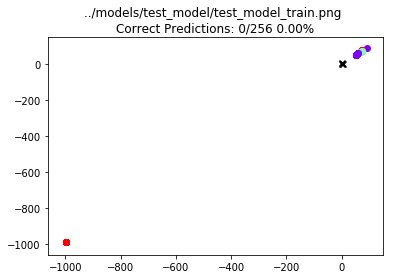

In [31]:
plot_predictions(model, '../models/' + model_name + '/' + model_name + '_train.png', 
                 [wifi_train, mag_train, images_train], y_train)

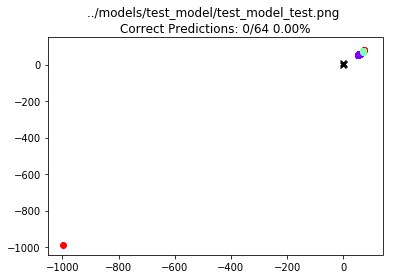

In [32]:
plot_predictions(model, '../models/' + model_name + '/' + model_name + '_test.png', 
                 [wifi_test, mag_test, images_test], y_test)